# EDA

In this note book we will perform EDA on our cleaned dataset. We will preliminarily create new features to explore before we finally perform a merge on the train and weather dataset in preparation for modelling.

## Problem Statement

In the past, Chicago has been hit by an outbreak of the West Nile Virus. The Data Science team at the Disease and Treatment Agency has been tasked by the Centers for Disease Control (CDC) to develop a strategy to deploy the effective use of targeted spraying to prevent future outbreaks.

Based on avilable data on features such as weather, location, mosquito species etc, we will build a binary classification model that predicts the presence of the West Nile Virus in the city of Chicago. The model that achieves the highest ROC AUC score on the validation set, will be selected as our production model. The model is also expected to outperform the baseline ROC AUC score of 0.5.

A cost-benefit analysis will also be done to determine if the benefits of spraying outweighs its costs.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import folium
from folium.plugins import HeatMap

from IPython.display import display
pd.set_option('display.max_colwidth', None)

train = pd.read_csv("./asset/train_cleaned.csv",index_col="date")
weather = pd.read_csv("./asset/weather_cleaned.csv",index_col="date")

In [2]:
# function with folium to map wnvpresent on physical map
def plotheatmap(time):
    map_virus = folium.Map(location=(train.latitude[0],train.longitude[0]), zoom_start=13,tiles="Stamen Terrain")

    virus_latlog = [[x, y] for x,y, virus, time 
                    in zip(train.latitude, train.longitude, train.wnvpresent, train[time])
                    if virus == 1]
    HeatMap(virus_latlog).add_to(map_virus)
    
    return map_virus

In [3]:
# create date, year, month and weekday feature from index
weather['date'] = pd.to_datetime(weather.index)
weather['year'] = weather.date.dt.year
weather['month'] = weather.date.dt.month
weather['weekday'] = weather.date.dt.weekday
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918 entries, 2007-05-01 to 2014-10-31
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2918 non-null   int64         
 1   tmax         2918 non-null   int64         
 2   tmin         2918 non-null   int64         
 3   tavg         2918 non-null   int64         
 4   depart       2918 non-null   int64         
 5   dewpoint     2918 non-null   int64         
 6   wetbulb      2918 non-null   int64         
 7   heat         2918 non-null   int64         
 8   cool         2918 non-null   int64         
 9   sunrise      2918 non-null   int64         
 10  sunset       2918 non-null   int64         
 11  snowfall     2918 non-null   float64       
 12  preciptotal  2918 non-null   float64       
 13  stnpressure  2918 non-null   float64       
 14  sealevel     2918 non-null   float64       
 15  resultspeed  2918 non-null   float64       
 

In [4]:
# create date, year, month and weekday feature from index
train['date'] = pd.to_datetime(train.index)
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['weekday'] = train.date.dt.weekday
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8475 entries, 2007-05-29 to 2013-09-26
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   address                 8475 non-null   object        
 1   species                 8475 non-null   object        
 2   block                   8475 non-null   int64         
 3   street                  8475 non-null   object        
 4   trap                    8475 non-null   object        
 5   addressnumberandstreet  8475 non-null   object        
 6   latitude                8475 non-null   float64       
 7   longitude               8475 non-null   float64       
 8   addressaccuracy         8475 non-null   int64         
 9   nummosquitos            8475 non-null   int64         
 10  wnvpresent              8475 non-null   int64         
 11  date                    8475 non-null   datetime64[ns]
 12  year                    8475 non-null 

## EDA for Train dataset
### Correlation Matrix & Heatmap
First we perform a correlation heatmap on the numerical data of the train dataset to check for multicollinearity. Findings from the heatmap suggest that there are no strong correlation among numerical data, even against the target.

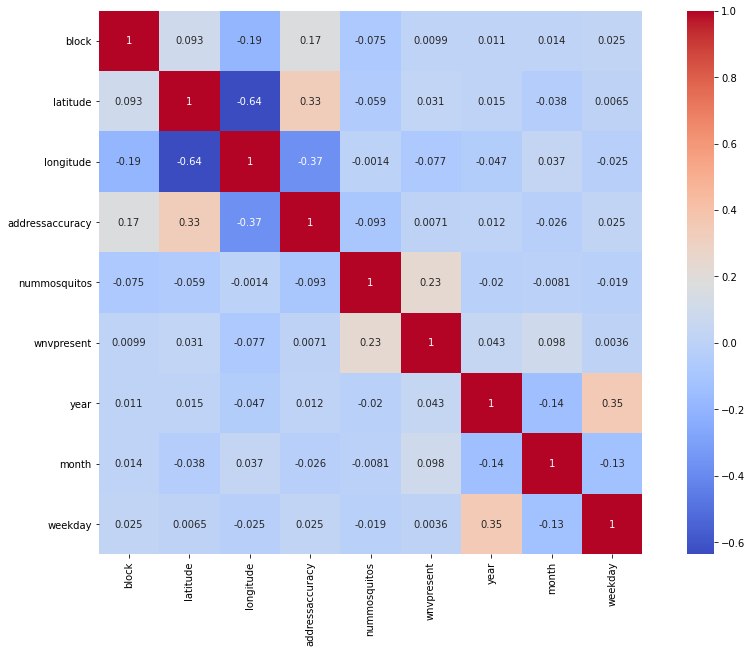

In [5]:
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(),square=True,annot=True,cmap='coolwarm');

### Mosquito species counts against presence of WNV
Next we plot a bar chart to see the total counts of mosquitos captured in the traps, as see how many tested positive for the virus. Finding shows that among the 7 categories, 3 categories of mosquitos carry the virus, consisting of 2 main species.

                        nummosquitos  wnvpresent
species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44488         184
CULEX PIPIENS/RESTUANS         65841         225
CULEX RESTUANS                 23326          48
CULEX SALINARIUS                 144           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  508           0


<Figure size 1152x720 with 0 Axes>

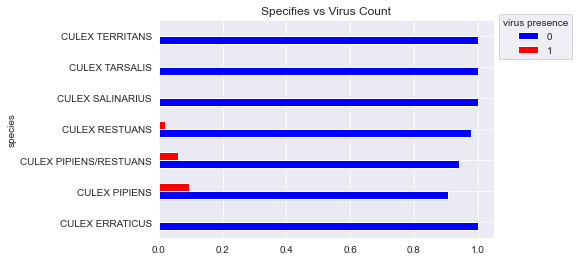

In [6]:
mos_present= train[["species","nummosquitos","wnvpresent"]].groupby(by="species").sum()
print(mos_present)
mos_present.reset_index(inplace=True)
plt.figure(figsize=(16,10))
sns.set_style('darkgrid')
ax = train.groupby(['species']).wnvpresent.value_counts(normalize=True).unstack().plot.barh(color = ['blue', 'red'])
ax.set_title('Specifies vs Virus Count')
ax.legend(bbox_to_anchor=(1.0, 1.05), title='virus presence');

### Positive Cases by Month
From graph below, there is an indication of correlation between temperature & presence of WNV virus. The 'phase' lag between temperature & WNV cases suggest the possibility summer being the most active phase of a mosquito's life cycle.

**Potential Feature Engineering:**
   1. Create a month feature
   2. Create a temperature feature based on $T = T_{-15days}$ based on mosquitor life cycle


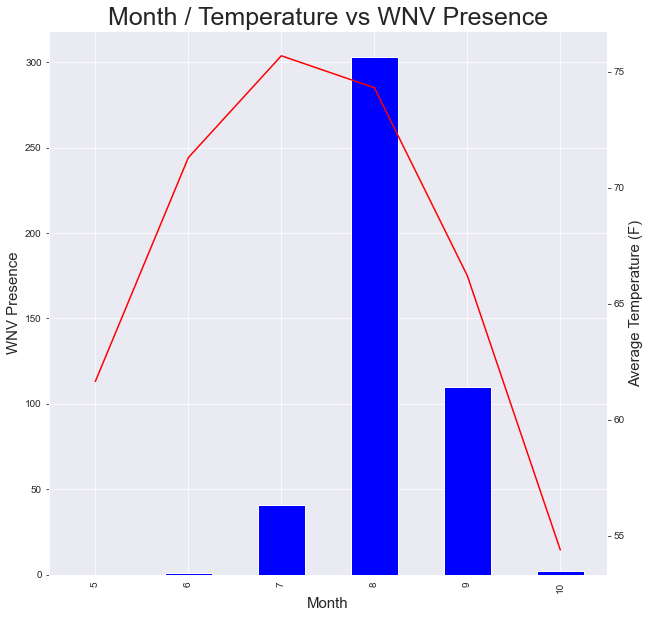

In [7]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
ax = train.groupby('month').wnvpresent.sum().plot.bar(color='blue')
ax1 = ax.twinx()
weather.groupby('month')['tavg'].mean().plot(ax=ax1, use_index=False, color='red');
ax.set_title('Month / Temperature vs WNV Presence',fontsize=25)
ax.set_ylabel('WNV Presence', fontsize=15)
ax1.set_ylabel('Average Temperature (F)', fontsize=15)
ax1.grid(None)
ax.set_xlabel('Month', fontsize=15);

In [8]:
plotheatmap('month')

Below we observe that there are particularly high counts of WNV presence in 2007 and 2013. Furthermore, below WNV counts grouped by days suggest that traps are only checked on weekdays.

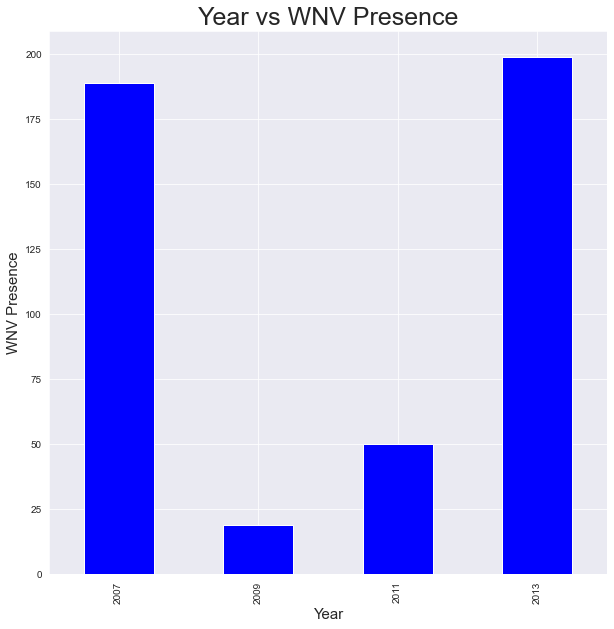

In [9]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
ax = train.groupby('year').wnvpresent.sum().plot.bar(color='blue')
ax.set_title('Year vs WNV Presence',fontsize=25)
ax.set_xlabel('Year', fontsize=15);
ax.set_ylabel('WNV Presence', fontsize=15);

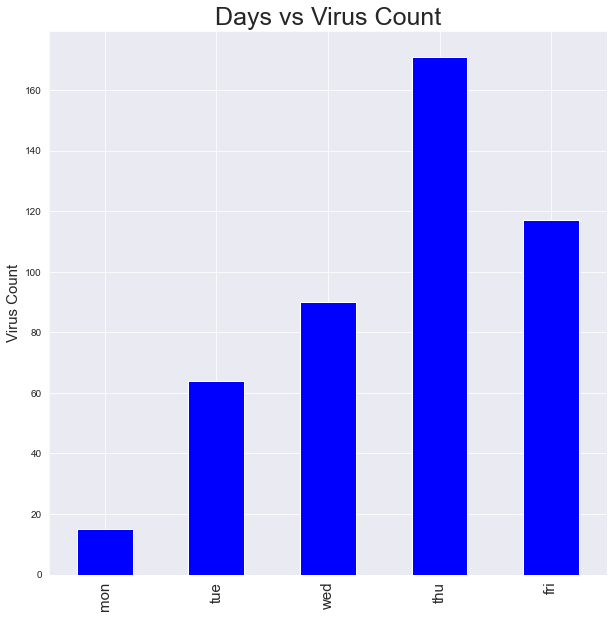

In [10]:
plt.figure(figsize=(10,10))
ax = train.groupby('weekday').wnvpresent.sum().plot.bar(color='blue')
ax.set_title('Days vs Virus Count',fontsize=25)
ax.set_ylabel('Virus Count',fontsize=15)
ax.set_xlabel("")
ax.set_xticklabels(["mon", "tue", "wed", 'thu', 'fri'],fontsize=15);

### Map Coordinates of Traps
Next we check for the coordinates of the traps placed around the area.

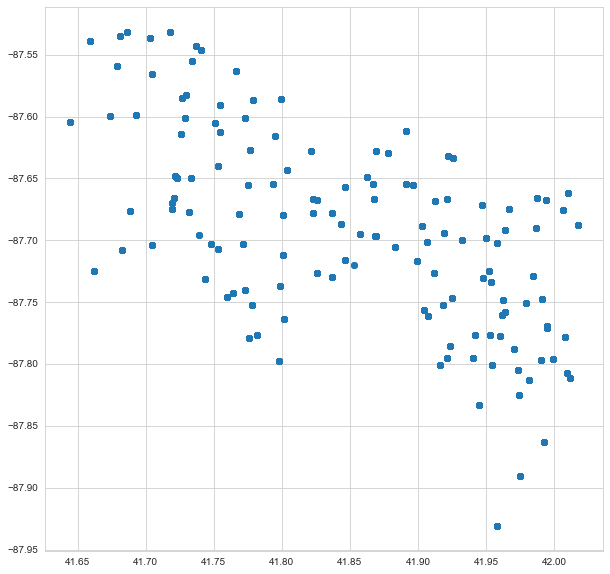

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
plt.scatter(train["latitude"],train['longitude']);

### Coordinates of Traps Against Positive and Negative Results (with Clustering)
Next we will perform a clustering for the positive cases, and also map them against the negative testing traps in the area.

In [12]:
X = train.loc[train["wnvpresent"]==1][["longitude","latitude"]] # for kmeans clustering
print("X",X.shape)

X2 = train.loc[train["wnvpresent"]==1].drop(["address","species","street","trap","addressnumberandstreet","date","year","month","weekday"],axis=1) # for DBScan
print("X2",X2.shape) 

X2_sc = MinMaxScaler().fit_transform(X2) # for DBScan

X (457, 2)
X2 (457, 6)


### DBSCAN
DBScan at epsilon = 0.35 produces 5 clusters and a single outlier. Below scatter plot shows the size of the clusters at each trap coordinates. The black dots represent instances where traps have 0 positive cases of WNV. The overlapping of black dots against the clusters suggest that mosquitos caught in the traps only test positive on certain instances. Further exploration on date and weather data might reveal new findings which will be explored further below.

In [13]:
dbscan_model = DBSCAN(eps=.35,min_samples=4).fit(X2_sc)
set(dbscan_model.labels_)

{-1, 0, 1, 2, 3, 4}

In [14]:
X2['DBSCAN_labels']=dbscan_model.labels_ 
X2['DBSCAN_labels'].value_counts()

 0    369
 1     38
 3     29
 2     11
 4      9
-1      1
Name: DBSCAN_labels, dtype: int64

In [15]:
# create feature of counts to scale scatter plot below
X2["coord"] = X2["latitude"] * X2["longitude"]
X2["counts"] = None
X2["counts"]= X2.groupby(["coord"]).transform('count')
X2

,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,DBSCAN_labels,coord,counts
date,,,,,,,,,
2007-07-18,38,41.686398,-87.531635,8,63,1,0,-3648.878574,3
2007-07-25,12,41.673408,-87.599862,5,2356,1,1,-3650.584790,15
2007-07-25,12,41.673408,-87.599862,5,644,1,1,-3650.584790,15
2007-08-01,22,41.688324,-87.676709,8,223,1,0,-3655.095052,7
2007-08-01,22,41.731922,-87.677512,8,17,1,0,-3658.951092,5
...,...,...,...,...,...,...,...,...,...
2013-09-19,11,41.868077,-87.666901,9,6,1,0,-3670.444561,7
2013-09-26,46,41.964242,-87.757639,8,3,1,0,-3682.682800,14
2013-09-26,51,41.763733,-87.742302,8,6,1,0,-3664.446074,2


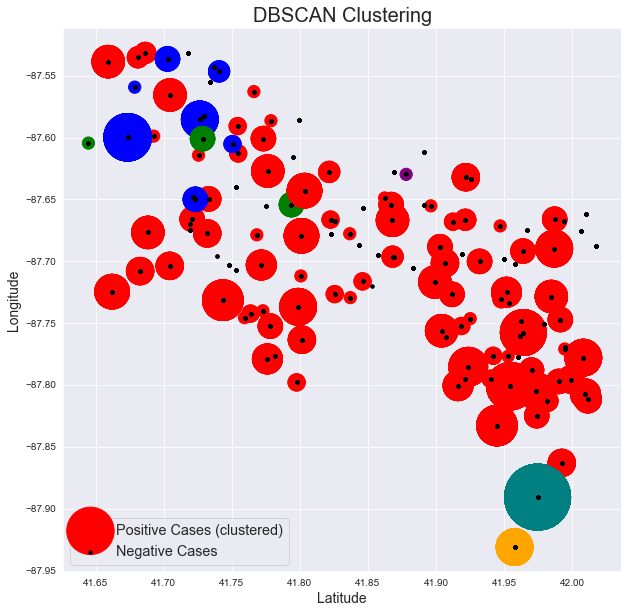

In [16]:
plt.figure(figsize=(10,10))


colors = ['purple','red','blue','green', "teal", "orange"]

sns.set_style('darkgrid')

plt.scatter(X2["latitude"],X2['longitude'],c=X2['DBSCAN_labels'],cmap=ListedColormap(colors),s=X2["counts"]*150,label = "Positive Cases (clustered)")
plt.scatter(train.loc[train["wnvpresent"]==0]["latitude"],train.loc[train["wnvpresent"]==0]['longitude'], c="black",s=10, label="Negative Cases")
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.legend(loc='lower left',fontsize="x-large");

### KMeans Clustering
Here we plot several cluster centroids to indicate possible "hot" zones for the WNV.

In [17]:
kmeans_model1 = KMeans(n_clusters=3,random_state=42).fit(X)
kmodel1 = pd.DataFrame(kmeans_model1.cluster_centers_,columns=["longitude",'latitude'])

kmeans_model2 = KMeans(n_clusters=2,random_state=42).fit(X)
kmodel2 = pd.DataFrame(kmeans_model2.cluster_centers_,columns=["longitude",'latitude'])

kmeans_model3 = KMeans(n_clusters=5,random_state=42).fit(X)
kmodel3 = pd.DataFrame(kmeans_model3.cluster_centers_,columns=["longitude",'latitude'])

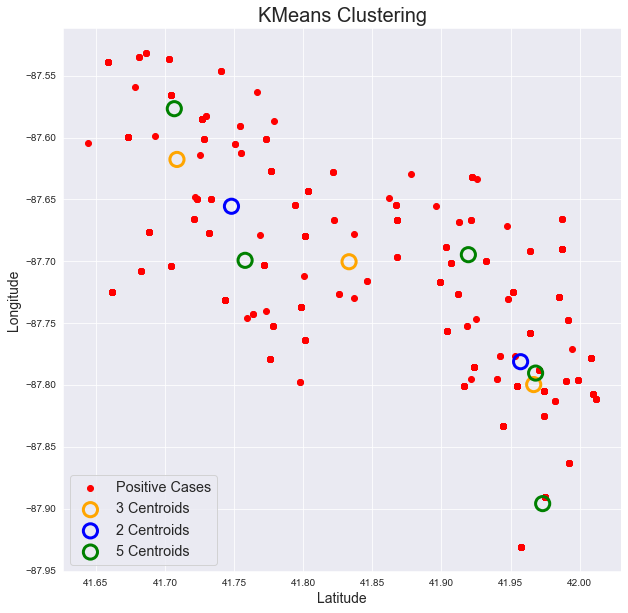

In [18]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))

plt.scatter(X["latitude"],X['longitude'], c="red", label="Positive Cases")
#plt.scatter(train.loc[train["wnvpresent"]==0]["latitude"],train.loc[train["wnvpresent"]==0]['longitude'], alpha=0.01, c="black")
plt.scatter(kmodel1["latitude"],kmodel1['longitude'],facecolors='none', edgecolors='orange', linewidth=3, s=200,label = "3 Centroids")
plt.scatter(kmodel2["latitude"],kmodel2['longitude'],facecolors='none', edgecolors='blue', linewidth=3, s=200,label = "2 Centroids")
plt.scatter(kmodel3["latitude"],kmodel3['longitude'],facecolors='none', edgecolors='green', linewidth=3, s=200, label = "5 Centroids")
plt.title('KMeans Clustering',fontsize=20)
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.legend(loc='lower left',fontsize="x-large");

In [19]:
# 2 cluster centers were chosen. Check for cluster center for future feature engineering
kmeans_model2.cluster_centers_

array([[-87.78117394,  41.95726979],
       [-87.65556425,  41.74808405]])

## EDA for Weather Dataset

Here we start off with a correlation heatmap. Immediately we can notice strong correlations among the temperature-based features. These also include some form of relationship between temperature, "Departure from normal", Sunrise and Sunset timings among other things. These can be combined into a singpe PCA for future modelling.

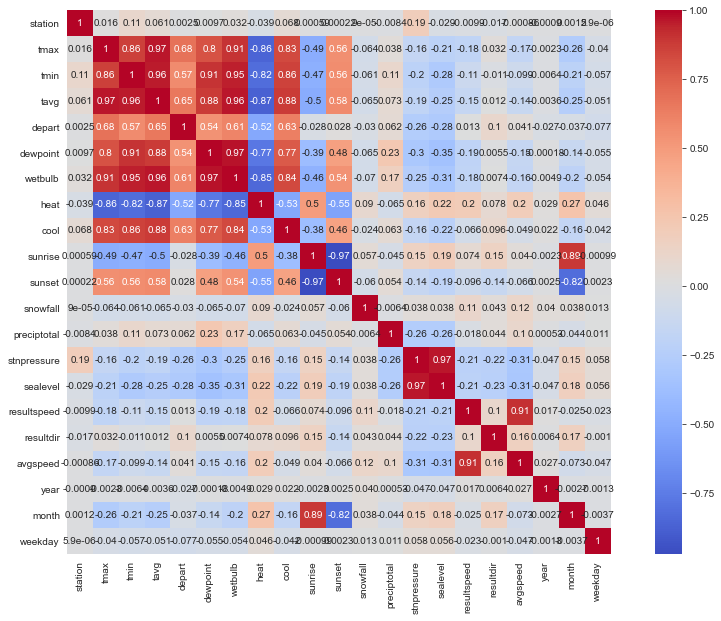

In [20]:
plt.figure(figsize=(16,10))
sns.heatmap(weather.corr(),square=True,annot=True,cmap='coolwarm');

### Variance between stations 1 & 2
We can see below that overall there is not much different in terms of station 1 and station 2 especially on the temperature feature. We can drop station 2 and proceed analysis with station 1

In [21]:
df_temp1 = weather.loc[weather.station == 1, :]
df_temp2 = weather.loc[weather.station == 2, :]

feature = weather.columns[1:18]
feature

Index(['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'sunrise', 'sunset', 'snowfall', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultdir', 'avgspeed'],
      dtype='object')

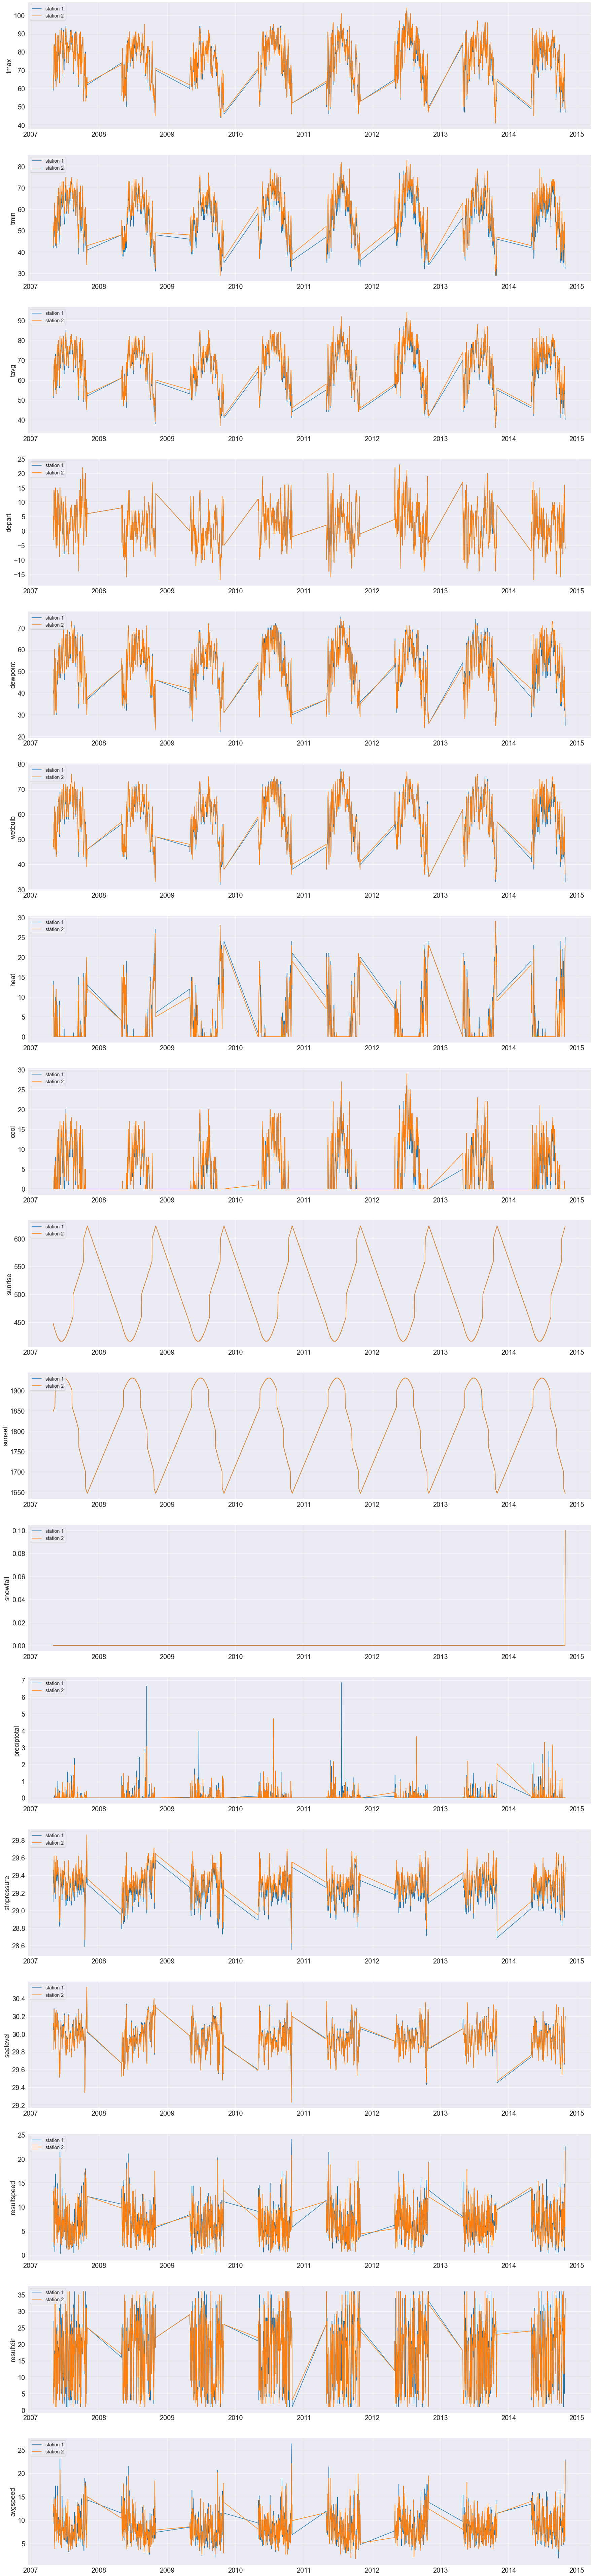

In [22]:
fig, ax = plt.subplots(nrows=len(feature), ncols=1, figsize=(30,140))
for row in range(len(feature)):
    sns.lineplot(x='date', y=feature[row], data=df_temp1, label='station 1', ax=ax[row])
    sns.lineplot(x='date', y=feature[row], data=df_temp2, label='station 2', ax=ax[row])
    ax[row].tick_params(axis='both', which='major', labelsize=20)
    ax[row].set_ylabel(feature[row], fontsize=20)
    ax[row].set_xlabel("")
    ax[row].legend(loc="upper left",fontsize="x-large");

Water temperature is one of the most important factors that account for development of larvae$^{1}$. Therefore we will pay more importance on the temperature feature

df = train.reset_index(drop=True)
df_weather = weather.loc[weather["Station"]==1].reset_index(drop=True)
df.merge(df_weather, how="left", on=['date'])
print("df", df.shape)
print("train",train.shape)
print("weather",weather.shape)
print("df weather",df_weather.shape)
df.head()

## Merge Dataframes

In [23]:
df = train.drop(['date', 'year', 'month', 'weekday'],axis=1)

# Since variance between the 2 stations are low, we will only consider station 1 for the merged dataset
df_weather = weather.loc[weather["station"]==1] #.drop(['date', 'year', 'month', 'weekday'],axis=1)
df_joined = pd.merge(df, df_weather,how='left', left_index=True, right_index=True)
df_joined.drop(["date","year","month","weekday"],axis=1,inplace=True)
print("df", df_joined.shape)
print("train",train.shape)
print("weather",weather.shape)
print("df weather",df_weather.shape)
df_joined.head()

df (8475, 29)
train (8475, 15)
weather (2918, 22)
df weather (1464, 22)


,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,...,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,...,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,...,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,1,...,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,...,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,1,...,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5


In [24]:
#check for missing values after joining dataframes
df_joined.isnull().sum()

address                    0
species                    0
block                      0
street                     0
trap                       0
addressnumberandstreet     0
latitude                   0
longitude                  0
addressaccuracy            0
nummosquitos               0
wnvpresent                 0
station                   88
tmax                      88
tmin                      88
tavg                      88
depart                    88
dewpoint                  88
wetbulb                   88
heat                      88
cool                      88
sunrise                   88
sunset                    88
snowfall                  88
preciptotal               88
stnpressure               88
sealevel                  88
resultspeed               88
resultdir                 88
avgspeed                  88
dtype: int64

In [25]:
# Since 88/8475 is approx. 1%, we can drop these data points.
df_joined.dropna(inplace=True)
df_joined.isnull().sum()

address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
station                   0
tmax                      0
tmin                      0
tavg                      0
depart                    0
dewpoint                  0
wetbulb                   0
heat                      0
cool                      0
sunrise                   0
sunset                    0
snowfall                  0
preciptotal               0
stnpressure               0
sealevel                  0
resultspeed               0
resultdir                 0
avgspeed                  0
dtype: int64

In [26]:
df_joined.shape

(8387, 29)

In [27]:
# In order to reduce more categorical data to minimize dummying, we will drop address type features while retaining
# longitude, latitude and trap number as our source of location information.
df_joined.drop(["address","block","street","addressnumberandstreet"],axis=1,inplace=True)
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8387 entries, 2007-05-29 to 2013-09-26
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   species          8387 non-null   object 
 1   trap             8387 non-null   object 
 2   latitude         8387 non-null   float64
 3   longitude        8387 non-null   float64
 4   addressaccuracy  8387 non-null   int64  
 5   nummosquitos     8387 non-null   int64  
 6   wnvpresent       8387 non-null   int64  
 7   station          8387 non-null   float64
 8   tmax             8387 non-null   float64
 9   tmin             8387 non-null   float64
 10  tavg             8387 non-null   float64
 11  depart           8387 non-null   float64
 12  dewpoint         8387 non-null   float64
 13  wetbulb          8387 non-null   float64
 14  heat             8387 non-null   float64
 15  cool             8387 non-null   float64
 16  sunrise          8387 non-null   float64
 17  suns

In [28]:
# Export
df_joined.to_csv("./asset/full_train.csv")

### Merging Kaggle Test Set

`text.csv` provided for kaggle submissions had some slight differences, the most significant being the absence of `nummosquitos`. This was a previously engineered feature for our train set. Other differences include the lack of target variable, as well as the presence of `Id` for submission purposes. `Id` will be dropped just before train test split.

In [29]:
test = pd.read_csv("./asset/test.csv",index_col="Date")
test.head()

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,2,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,3,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,4,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,5,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [30]:
test_joined = pd.merge(test, df_weather,how='left', left_index=True, right_index=True)

# Similar to the train set, we will drop the following features to retain as much similarity to the train set as possible.
test_joined.drop(["date","year","month","weekday","Address","AddressNumberAndStreet","Street","Block"],axis=1,inplace=True)

# convert all column headers to lower case, replace spaces with '_'
test_joined.columns = test_joined.columns.str.replace(' ' , '_')
test_joined.columns = test_joined.columns.str.lower()
print(test_joined.columns.tolist())

['id', 'species', 'trap', 'latitude', 'longitude', 'addressaccuracy', 'station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']


In [31]:
# Check for missing values
test_joined.isnull().sum()

id                 0
species            0
trap               0
latitude           0
longitude          0
addressaccuracy    0
station            0
tmax               0
tmin               0
tavg               0
depart             0
dewpoint           0
wetbulb            0
heat               0
cool               0
sunrise            0
sunset             0
snowfall           0
preciptotal        0
stnpressure        0
sealevel           0
resultspeed        0
resultdir          0
avgspeed           0
dtype: int64

In [32]:
# Export
test_joined.to_csv("./asset/full_test.csv")
